**Libraries to import**

In [ ]:
import os

#os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
#os.environ["CUDA_VISIBLE_DEVICES"]="0,3"  # specify which GPU(s) to be used # Will use only the first and the fourth GPU devices
os.environ["CUDA_VISIBLE_DEVICES"] = "-1" #To ensure that a GPU version TensorFlow process only runs on CPU.
#Note that you can allocate GPU Memory if desired. Preallocate or Allow Growth.
import pickle
import random as rn
import math 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.models import load_model
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split 
from keras.layers.advanced_activations import LeakyReLU

pd.set_option('display.max_columns', 200)

**To check GPU (Method-1)**

In [ ]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

**To check GPU (Method-2) & To use GPU**

In [ ]:
print(tf.__version__)

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

2.5.0
1 Physical GPUs, 1 Logical GPUs


**To reset Random Seed**

In [ ]:
def reset_seed(seed=0):
    os.environ['PYTHONHASHSEED'] = '0'
    rn.seed(seed) # fix random function seed
    np.random.seed(seed) # fix numpy seed
    tf.random.set_seed(seed) # fix tensorflow seed

**To plot**

In [ ]:
def yyplot(y_true, y_pred):
    yvalues = np.concatenate([y_true.flatten(), y_pred.flatten()])
    ymin, ymax, yrange = np.amin(yvalues), np.amax(yvalues), np.ptp(yvalues)
    fig = plt.figure(figsize=(8, 8))
    plt.scatter(y_true, y_pred, s=1.0)
    plt.plot([ymin - yrange * 0.01, ymax + yrange * 0.01], [ymin - yrange * 0.01, ymax + yrange * 0.01], color="red", linestyle = "dashed")
    plt.xlim(ymin - yrange * 0.01, ymax + yrange * 0.01)
    plt.ylim(ymin - yrange * 0.01, ymax + yrange * 0.01)
    plt.xlabel('t: true value')
    plt.ylabel('y: predicted value')
    plt.title('True-Predicted Plot')
    plt.show()
    return fig

**For Matrices**

In [ ]:
def metrics(y_true, y_pred):
    metrics = [r2_score(y_true=y_true, y_pred=y_pred), 
               np.sqrt(mean_squared_error(y_true=y_true, y_pred=y_pred)), 
               mean_absolute_error(y_true=y_true, y_pred=y_pred)
              ]
    return metrics

**To Fix random seed**

In [ ]:
reset_seed(1234)

**To read pkl Dataset**

In [ ]:
in_path = 'gen_model2_preprocessed_0126.pkl' #not there now
df_raw = pd.read_pickle(in_path)
df_raw.describe()

**To read csv Dataset in bulk**

In [ ]:
#Data Loading
import glob

folder_path="/content/drive/MyDrive/Dataset Collection/condifiential"

all_files = glob.glob(folder_path+"/*.csv") #beware backslash or slash
print(all_files)

list = []

for file_name in all_files:
    df_each = pd.read_csv(file_name)
    list.append(df_each)

df_raw = pd.concat(list, axis=0, ignore_index=True)
df_raw.head(10)

['/content/drive/MyDrive/Dataset Collection/condifiential/conditions.csv']


,Unnamed: 0,FEED_N2,FEED_C1,FEED_C2,FEED_C3,FEED_iC4,FEED_nC4,FEED_C5+,AmbTemp,C3_CON_OUT,P_HPMR,P_LPMR,MCHE_BTM_DT,WB_UA,CB_UA,MR_N2,MR_C1,MR_C2,MR_C3,LMR_GASFLOW,FFF_Flow,SpecPower,ThermalEff,MCHE_OUT_T,MCHE_OUT_C_T,MCHE_MID_T,MCHE_MID_C_T,MCHE_IN_T,MCHE_IN_C_T,MR_GASFLOW,HMR_VFLOW,C3_GT_Power,LPMR_GT_Power,HPMR_GT_Power,LNG_Dens,Feasible,Note
0,1,1.0,92.8,3.5,1.8,0.45,0.45,0.0,35.0,59.2,60.0,1.82,2.0,1.546189e+07,8.318682e+05,6.0,39.2,41.4,13.4,82577.831748,-13720.876536,332.107788,0.865917,-144.45,-157.123012,-130.7,-134.387506,-29.057614,-30.418066,523547.289463,948.090364,32094.859507,31162.609095,28238.272503,431.668540,0,Less CB_UA
1,2,0.8,92.5,3.8,1.9,0.50,0.50,0.0,26.0,50.7,55.0,2.04,3.5,1.498481e+07,1.462980e+06,5.9,40.0,41.0,13.1,100573.850142,-19057.619215,304.504133,0.856291,-142.85,-155.746662,-123.7,-129.108945,-32.946088,-35.806928,518666.152335,916.788148,29456.397003,28645.389152,25121.595618,430.825451,1,NaN
2,3,0.7,92.6,3.9,1.8,0.50,0.50,0.0,29.0,51.2,51.5,2.12,4.0,1.307228e+07,1.985647e+06,7.0,38.6,42.2,12.2,138965.462506,-24098.821405,315.779516,0.839024,-140.25,-155.187382,-112.7,-120.806175,-32.719113,-36.075322,536581.043640,901.220792,30811.395298,29087.079884,24825.521479,426.368432,1,NaN
3,4,0.8,92.7,3.9,1.5,0.55,0.55,0.0,26.0,48.7,58.5,1.74,3.5,1.483471e+07,3.697995e+05,5.5,38.2,42.9,13.4,41882.520568,-29966.254445,296.544838,0.825383,-138.25,-155.813934,-130.7,-135.479967,-33.855187,-36.718666,467442.084959,910.984718,26848.362158,27574.401777,23759.817701,422.721526,0,Less CB_UA
4,5,0.9,92.3,3.7,1.7,0.70,0.70,0.0,21.5,43.2,56.0,1.94,7.0,1.488466e+07,1.240289e+06,6.4,40.2,40.7,12.7,85679.953279,-13896.706791,287.889113,0.875096,-145.65,-158.629441,-129.4,-133.401140,-36.335160,-42.696639,511696.263080,916.628985,27353.667120,28126.430499,24792.959363,436.953577,1,NaN
5,6,0.6,92.2,4.0,2.0,0.60,0.60,0.0,36.0,60.2,55.0,1.92,7.0,1.591572e+07,2.239318e+06,6.3,39.6,40.7,13.4,148565.215556,6407.334393,338.347548,0.905353,-153.05,-160.497889,-129.8,-132.226866,-28.596722,-34.949752,595508.378668,974.469311,35972.172431,33970.501378,29967.412069,447.747528,1,NaN
6,7,0.8,92.5,3.8,2.0,0.45,0.45,0.0,32.0,56.7,59.0,2.08,2.0,1.426342e+07,1.970134e+06,6.0,41.1,43.6,9.3,113778.987211,-1549.210283,332.547632,0.902009,-149.85,-158.048943,-132.6,-134.449316,-30.204236,-31.557764,571721.553878,967.574862,33227.998869,32052.997488,30373.196841,440.970136,1,NaN
7,8,0.8,92.5,3.4,2.0,0.65,0.65,0.0,21.0,45.7,52.0,1.72,2.5,1.548254e+07,1.868048e+06,7.0,39.7,41.3,12.0,135946.158671,3988.623707,297.080897,0.915010,-153.65,-162.755067,-129.5,-132.768155,-35.211522,-37.071076,553871.014653,907.167067,29672.986051,32987.392437,25108.163896,448.272238,1,NaN
8,9,0.6,92.0,3.9,2.0,0.75,0.75,0.0,24.0,49.2,58.5,2.02,2.0,1.569499e+07,2.249025e+06,6.6,41.8,40.2,11.4,110526.408165,2394.812727,303.435626,0.913290,-152.45,-160.745104,-134.2,-135.815741,-33.626440,-34.980192,552200.329598,935.096131,30122.311502,30923.827509,28226.952131,448.795859,1,NaN
9,10,0.9,92.0,3.8,1.8,0.75,0.75,0.0,27.5,49.7,50.0,2.16,5.5,1.484059e+07,2.214760e+06,6.7,42.8,42.5,8.0,228826.822707,10121.228974,333.409414,0.907636,-155.25,-160.261631,-137.6,-138.523893,-33.400016,-38.256917,653664.552452,898.797471,34708.107253,35119.992698,29631.659429,452.373362,1,NaN


**To duplicate dataframe**

In [ ]:
df = df_raw.copy()

**To remove some columns**

In [ ]:
# remove Note and Unnamed columns
df.drop(["Note", "Unnamed: 0"], axis = 1, inplace = True)
df.head(10)

,FEED_N2,FEED_C1,FEED_C2,FEED_C3,FEED_iC4,FEED_nC4,FEED_C5+,AmbTemp,C3_CON_OUT,P_HPMR,P_LPMR,MCHE_BTM_DT,WB_UA,CB_UA,MR_N2,MR_C1,MR_C2,MR_C3,LMR_GASFLOW,FFF_Flow,SpecPower,ThermalEff,MCHE_OUT_T,MCHE_OUT_C_T,MCHE_MID_T,MCHE_MID_C_T,MCHE_IN_T,MCHE_IN_C_T,MR_GASFLOW,HMR_VFLOW,C3_GT_Power,LPMR_GT_Power,HPMR_GT_Power,LNG_Dens,Feasible
0,1.0,92.8,3.5,1.8,0.45,0.45,0.0,35.0,59.2,60.0,1.82,2.0,1.546189e+07,8.318682e+05,6.0,39.2,41.4,13.4,82577.831748,-13720.876536,332.107788,0.865917,-144.45,-157.123012,-130.7,-134.387506,-29.057614,-30.418066,523547.289463,948.090364,32094.859507,31162.609095,28238.272503,431.668540,0
1,0.8,92.5,3.8,1.9,0.50,0.50,0.0,26.0,50.7,55.0,2.04,3.5,1.498481e+07,1.462980e+06,5.9,40.0,41.0,13.1,100573.850142,-19057.619215,304.504133,0.856291,-142.85,-155.746662,-123.7,-129.108945,-32.946088,-35.806928,518666.152335,916.788148,29456.397003,28645.389152,25121.595618,430.825451,1
2,0.7,92.6,3.9,1.8,0.50,0.50,0.0,29.0,51.2,51.5,2.12,4.0,1.307228e+07,1.985647e+06,7.0,38.6,42.2,12.2,138965.462506,-24098.821405,315.779516,0.839024,-140.25,-155.187382,-112.7,-120.806175,-32.719113,-36.075322,536581.043640,901.220792,30811.395298,29087.079884,24825.521479,426.368432,1
3,0.8,92.7,3.9,1.5,0.55,0.55,0.0,26.0,48.7,58.5,1.74,3.5,1.483471e+07,3.697995e+05,5.5,38.2,42.9,13.4,41882.520568,-29966.254445,296.544838,0.825383,-138.25,-155.813934,-130.7,-135.479967,-33.855187,-36.718666,467442.084959,910.984718,26848.362158,27574.401777,23759.817701,422.721526,0
4,0.9,92.3,3.7,1.7,0.70,0.70,0.0,21.5,43.2,56.0,1.94,7.0,1.488466e+07,1.240289e+06,6.4,40.2,40.7,12.7,85679.953279,-13896.706791,287.889113,0.875096,-145.65,-158.629441,-129.4,-133.401140,-36.335160,-42.696639,511696.263080,916.628985,27353.667120,28126.430499,24792.959363,436.953577,1
5,0.6,92.2,4.0,2.0,0.60,0.60,0.0,36.0,60.2,55.0,1.92,7.0,1.591572e+07,2.239318e+06,6.3,39.6,40.7,13.4,148565.215556,6407.334393,338.347548,0.905353,-153.05,-160.497889,-129.8,-132.226866,-28.596722,-34.949752,595508.378668,974.469311,35972.172431,33970.501378,29967.412069,447.747528,1
6,0.8,92.5,3.8,2.0,0.45,0.45,0.0,32.0,56.7,59.0,2.08,2.0,1.426342e+07,1.970134e+06,6.0,41.1,43.6,9.3,113778.987211,-1549.210283,332.547632,0.902009,-149.85,-158.048943,-132.6,-134.449316,-30.204236,-31.557764,571721.553878,967.574862,33227.998869,32052.997488,30373.196841,440.970136,1
7,0.8,92.5,3.4,2.0,0.65,0.65,0.0,21.0,45.7,52.0,1.72,2.5,1.548254e+07,1.868048e+06,7.0,39.7,41.3,12.0,135946.158671,3988.623707,297.080897,0.915010,-153.65,-162.755067,-129.5,-132.768155,-35.211522,-37.071076,553871.014653,907.167067,29672.986051,32987.392437,25108.163896,448.272238,1
8,0.6,92.0,3.9,2.0,0.75,0.75,0.0,24.0,49.2,58.5,2.02,2.0,1.569499e+07,2.249025e+06,6.6,41.8,40.2,11.4,110526.408165,2394.812727,303.435626,0.913290,-152.45,-160.745104,-134.2,-135.815741,-33.626440,-34.980192,552200.329598,935.096131,30122.311502,30923.827509,28226.952131,448.795859,1
9,0.9,92.0,3.8,1.8,0.75,0.75,0.0,27.5,49.7,50.0,2.16,5.5,1.484059e+07,2.214760e+06,6.7,42.8,42.5,8.0,228826.822707,10121.228974,333.409414,0.907636,-155.25,-160.261631,-137.6,-138.523893,-33.400016,-38.256917,653664.552452,898.797471,34708.107253,35119.992698,29631.659429,452.373362,1


**To visualize each tag**

12


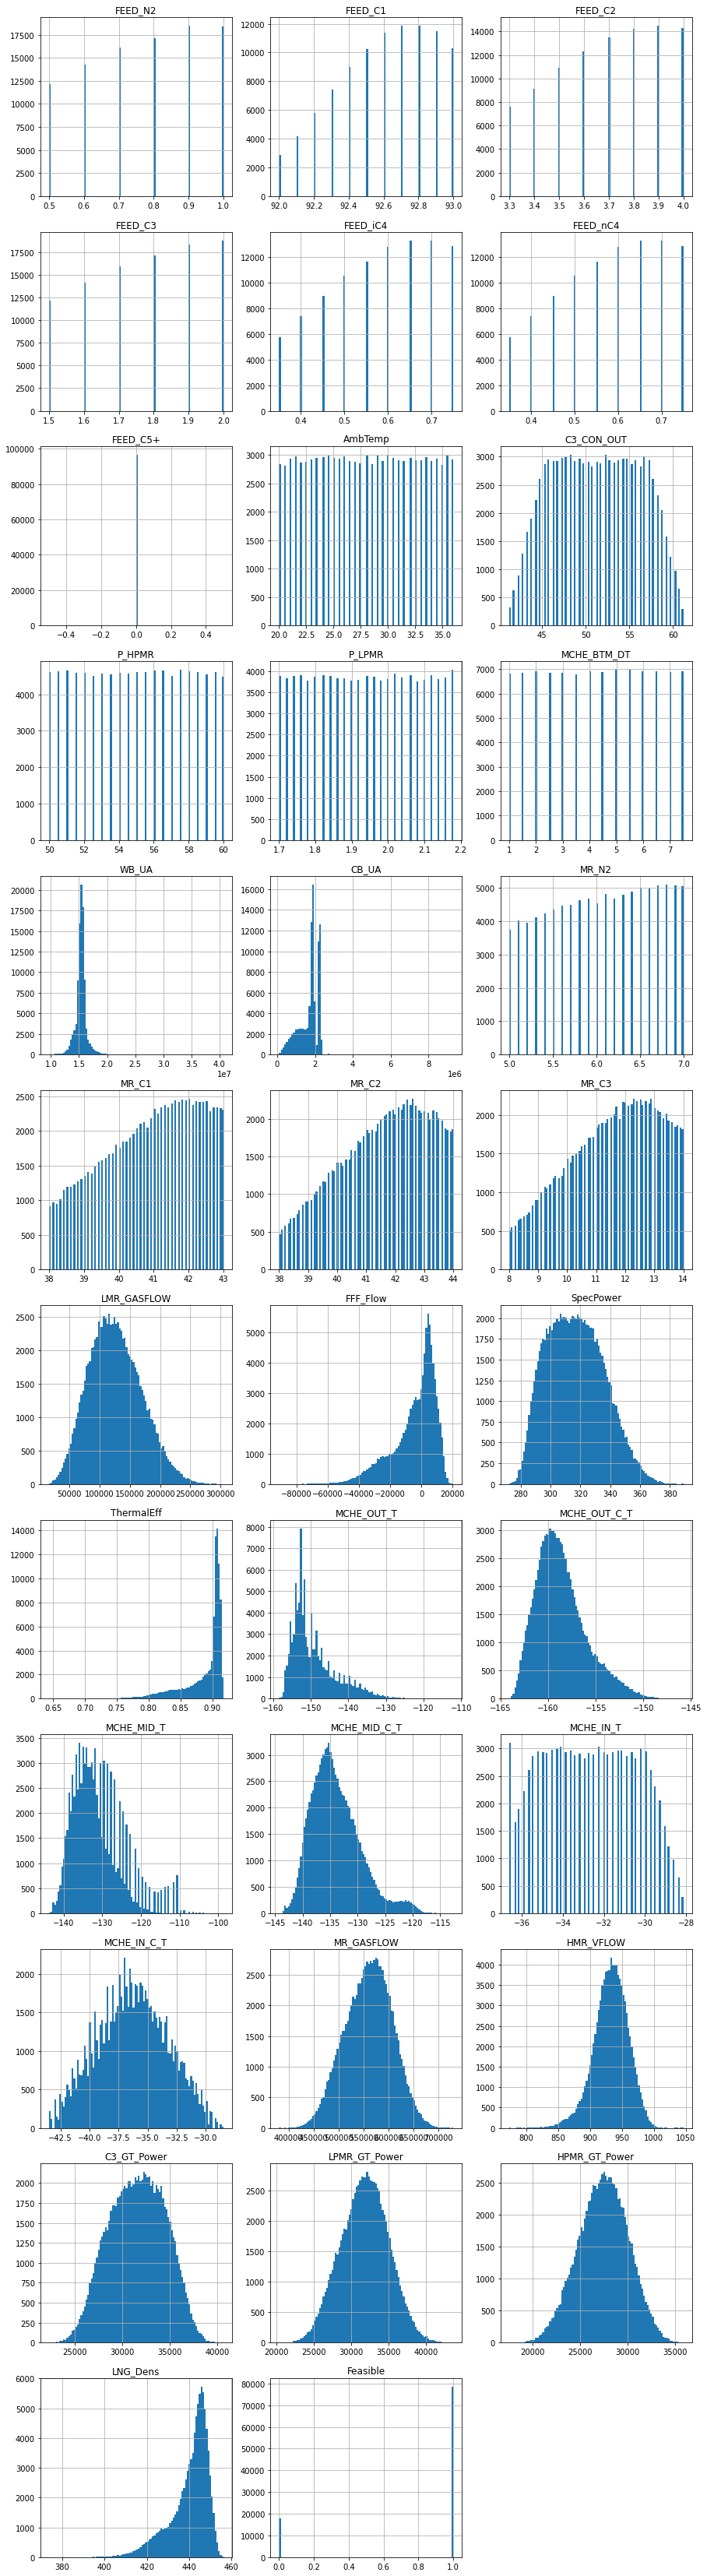

In [ ]:
# Visuallization of each tag
#to be updated# 
num_row = math.ceil(len(df.columns) / 3)
print(num_row)

plt.figure(figsize=(15, 5 * num_row))
i=0

for tag in df.columns:
    i += 1
     
    plt.subplot(num_row, 3, i)
    x1=df[tag]
    plt.hist(x=x1, bins=100)
    plt.grid()
    plt.title(label=tag)
    
plt.show()

**To remove non-feasible rows**

In [ ]:
df = df[df['Feasible'] != 0]
df.head(10)

,FEED_N2,FEED_C1,FEED_C2,FEED_C3,FEED_iC4,FEED_nC4,FEED_C5+,AmbTemp,C3_CON_OUT,P_HPMR,P_LPMR,MCHE_BTM_DT,WB_UA,CB_UA,MR_N2,MR_C1,MR_C2,MR_C3,LMR_GASFLOW,FFF_Flow,SpecPower,ThermalEff,MCHE_OUT_T,MCHE_OUT_C_T,MCHE_MID_T,MCHE_MID_C_T,MCHE_IN_T,MCHE_IN_C_T,MR_GASFLOW,HMR_VFLOW,C3_GT_Power,LPMR_GT_Power,HPMR_GT_Power,LNG_Dens,Feasible
1,0.8,92.5,3.8,1.9,0.50,0.50,0.0,26.0,50.7,55.0,2.04,3.5,1.498481e+07,1.462980e+06,5.9,40.0,41.0,13.1,100573.850142,-19057.619215,304.504133,0.856291,-142.85,-155.746662,-123.7,-129.108945,-32.946088,-35.806928,518666.152335,916.788148,29456.397003,28645.389152,25121.595618,430.825451,1
2,0.7,92.6,3.9,1.8,0.50,0.50,0.0,29.0,51.2,51.5,2.12,4.0,1.307228e+07,1.985647e+06,7.0,38.6,42.2,12.2,138965.462506,-24098.821405,315.779516,0.839024,-140.25,-155.187382,-112.7,-120.806175,-32.719113,-36.075322,536581.043640,901.220792,30811.395298,29087.079884,24825.521479,426.368432,1
4,0.9,92.3,3.7,1.7,0.70,0.70,0.0,21.5,43.2,56.0,1.94,7.0,1.488466e+07,1.240289e+06,6.4,40.2,40.7,12.7,85679.953279,-13896.706791,287.889113,0.875096,-145.65,-158.629441,-129.4,-133.401140,-36.335160,-42.696639,511696.263080,916.628985,27353.667120,28126.430499,24792.959363,436.953577,1
5,0.6,92.2,4.0,2.0,0.60,0.60,0.0,36.0,60.2,55.0,1.92,7.0,1.591572e+07,2.239318e+06,6.3,39.6,40.7,13.4,148565.215556,6407.334393,338.347548,0.905353,-153.05,-160.497889,-129.8,-132.226866,-28.596722,-34.949752,595508.378668,974.469311,35972.172431,33970.501378,29967.412069,447.747528,1
6,0.8,92.5,3.8,2.0,0.45,0.45,0.0,32.0,56.7,59.0,2.08,2.0,1.426342e+07,1.970134e+06,6.0,41.1,43.6,9.3,113778.987211,-1549.210283,332.547632,0.902009,-149.85,-158.048943,-132.6,-134.449316,-30.204236,-31.557764,571721.553878,967.574862,33227.998869,32052.997488,30373.196841,440.970136,1
7,0.8,92.5,3.4,2.0,0.65,0.65,0.0,21.0,45.7,52.0,1.72,2.5,1.548254e+07,1.868048e+06,7.0,39.7,41.3,12.0,135946.158671,3988.623707,297.080897,0.915010,-153.65,-162.755067,-129.5,-132.768155,-35.211522,-37.071076,553871.014653,907.167067,29672.986051,32987.392437,25108.163896,448.272238,1
8,0.6,92.0,3.9,2.0,0.75,0.75,0.0,24.0,49.2,58.5,2.02,2.0,1.569499e+07,2.249025e+06,6.6,41.8,40.2,11.4,110526.408165,2394.812727,303.435626,0.913290,-152.45,-160.745104,-134.2,-135.815741,-33.626440,-34.980192,552200.329598,935.096131,30122.311502,30923.827509,28226.952131,448.795859,1
9,0.9,92.0,3.8,1.8,0.75,0.75,0.0,27.5,49.7,50.0,2.16,5.5,1.484059e+07,2.214760e+06,6.7,42.8,42.5,8.0,228826.822707,10121.228974,333.409414,0.907636,-155.25,-160.261631,-137.6,-138.523893,-33.400016,-38.256917,653664.552452,898.797471,34708.107253,35119.992698,29631.659429,452.373362,1
10,0.5,92.9,3.7,1.5,0.70,0.70,0.0,31.0,52.7,56.0,1.76,5.5,1.537462e+07,1.893312e+06,6.0,40.7,40.0,13.3,115598.046459,2029.034401,318.002330,0.909666,-151.85,-160.460083,-131.9,-134.338990,-32.036013,-36.894984,560040.357810,957.002424,32088.998531,32976.488093,28133.067154,443.877622,1
11,0.9,92.7,3.4,1.6,0.70,0.70,0.0,24.0,47.7,59.0,1.94,3.0,1.540220e+07,1.277334e+06,6.3,40.0,43.9,9.8,73957.121239,-8318.717847,301.669902,0.888834,-147.85,-159.215840,-135.9,-137.607757,-34.308054,-36.669280,523023.591321,939.605641,28895.812033,29622.926594,26890.981324,438.867762,1


**To prepare Scalar File Function**

In [ ]:
sc_x = StandardScaler()
sc_y = StandardScaler()

**To prepare raw Feature list by column names in list**

In [ ]:
#To be updated according to the Specification#

# explanatory variable - given
list_u = [
    'FEED_N2',
    'FEED_C1',
    'FEED_C2',
    'FEED_C3',
#     'FEED_iC4',
#     'FEED_nC4',
#     'FEED_C5+',
    'AmbTemp',
    'C3_CON_OUT',
#     'MCHE_IN_T',
    'WB_UA',
    'CB_UA'
]

# explanatory variable - search
list_v = [
    'P_HPMR',
    'P_LPMR',
    'MCHE_BTM_DT',
#     'MR_N2',
    'MR_C1',
    'MR_C2',
    'MR_C3'
]

list_x = list_u + list_v

**To extract Feature DataFrame from overall DataFrame**

In [ ]:
df_x = df.loc[:, list_x] #.loc allows with column name, where .iloc allows only index number
df_x.describe()

,FEED_N2,FEED_C1,FEED_C2,FEED_C3,AmbTemp,C3_CON_OUT,WB_UA,CB_UA,P_HPMR,P_LPMR,MCHE_BTM_DT,MR_C1,MR_C2,MR_C3
count,78492.000000,78492.000000,78492.000000,78492.000000,78492.000000,78492.000000,7.849200e+04,7.849200e+04,78492.000000,78492.000000,78492.000000,78492.000000,78492.000000,78492.000000
mean,0.772967,92.597098,3.694397,1.775303,28.561713,51.796812,1.544166e+07,1.902363e+06,54.578231,1.935224,4.310382,41.152441,41.444184,11.298211
std,0.166580,0.277516,0.218594,0.166677,4.682627,4.836847,9.387198e+05,3.000158e+05,2.967038,0.144139,2.010944,1.249483,1.597669,1.545636
min,0.500000,92.000000,3.300000,1.500000,20.000000,41.200000,1.147112e+07,9.885195e+05,50.000000,1.700000,1.000000,38.000000,38.000000,8.000000
25%,0.600000,92.400000,3.500000,1.600000,24.500000,47.700000,1.502264e+07,1.774307e+06,52.000000,1.820000,2.500000,40.300000,40.200000,10.100000
50%,0.800000,92.600000,3.700000,1.800000,29.000000,52.200000,1.546086e+07,1.894295e+06,54.500000,1.940000,4.500000,41.300000,41.600000,11.400000
75%,0.900000,92.800000,3.900000,1.900000,32.500000,55.700000,1.583172e+07,2.196960e+06,57.000000,2.060000,6.000000,42.200000,42.800000,12.500000
max,1.000000,93.000000,4.000000,2.000000,36.000000,61.200000,2.128458e+07,2.946253e+06,60.000000,2.180000,7.500000,43.000000,44.000000,14.000000


**To prepare Label list**

In [ ]:
df_y = df.loc[:, ['FFF_Flow']] #df_y = df.loc[:, ['ThermalEff']]
df_y.describe()

,FFF_Flow
count,78492.000000
mean,20.008117
std,9804.950969
min,-51230.352279
25%,-4867.963360
50%,2291.899625
75%,6589.746923
max,20473.859216


**To train, we need numpy array instead of Pandas DataFrame**

In [ ]:
x = df_x.values
y = df_y.values

**Using Standard Scalar method, transform x and y to normalized ones.**

In [ ]:
x_scaled = sc_x.fit_transform(x)
y_scaled = sc_y.fit_transform(y)

**To save in scalar files**

In [ ]:
from pickle import dump
dump(sc_x, open('/content/drive/MyDrive/Dataset Collection/condifiential/FFF_Flow_sc_x.pkl', 'wb'))
dump(sc_y, open('/content/drive/MyDrive/Dataset Collection/condifiential/FFF_Flow__sc_y.pkl', 'wb'))

**To split Train & Test Data**

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x_scaled, y_scaled, test_size=0.1, random_state=0)

**To create Model**

In [ ]:
input_dim = x_train.shape[1]
output_dim = y_train.shape[1]

model = Sequential()
model.add(Dense(units=25, input_dim=input_dim, activation='tanh'))
model.add(Dense(units=10, activation='tanh'))
#model.add(Dense(units=5, activation='tanh'))
model.add(Dense(units=output_dim))
opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='mean_squared_error')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 25)                375       
_________________________________________________________________
dense_1 (Dense)              (None, 10)                260       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 646
Trainable params: 646
Non-trainable params: 0
_________________________________________________________________


**To save the best model**

In [ ]:
model_path_out = '/content/drive/MyDrive/Dataset Collection/condifiential/FFF_Flow_best.h5'
mc = ModelCheckpoint(filepath=model_path_out, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

**To start Traininig**

To know Training Time, use %%time , which is jupyter notebook function.

In [ ]:
%%time
history = model.fit(x=x_train, y=y_train, batch_size=128, epochs=1000, verbose=1, callbacks=[mc], validation_data=(x_test, y_test))

Epoch 1/1000
552/552 [==============================] - 15s 3ms/step - loss: 0.5012 - val_loss: 0.0730

Epoch 00001: val_loss improved from inf to 0.07299, saving model to /content/drive/MyDrive/Dataset Collection/condifiential/FFF_Flow_best.h5
Epoch 2/1000
552/552 [==============================] - 1s 2ms/step - loss: 0.0546 - val_loss: 0.0217

Epoch 00002: val_loss improved from 0.07299 to 0.02171, saving model to /content/drive/MyDrive/Dataset Collection/condifiential/FFF_Flow_best.h5
Epoch 3/1000
552/552 [==============================] - 1s 2ms/step - loss: 0.0179 - val_loss: 0.0104

Epoch 00003: val_loss improved from 0.02171 to 0.01038, saving model to /content/drive/MyDrive/Dataset Collection/condifiential/FFF_Flow_best.h5
Epoch 4/1000
552/552 [==============================] - 1s 2ms/step - loss: 0.0092 - val_loss: 0.0061

Epoch 00004: val_loss improved from 0.01038 to 0.00608, saving model to /content/drive/MyDrive/Dataset Collection/condifiential/FFF_Flow_best.h5
Epoch 5/100

**To visualize Learning Curve**

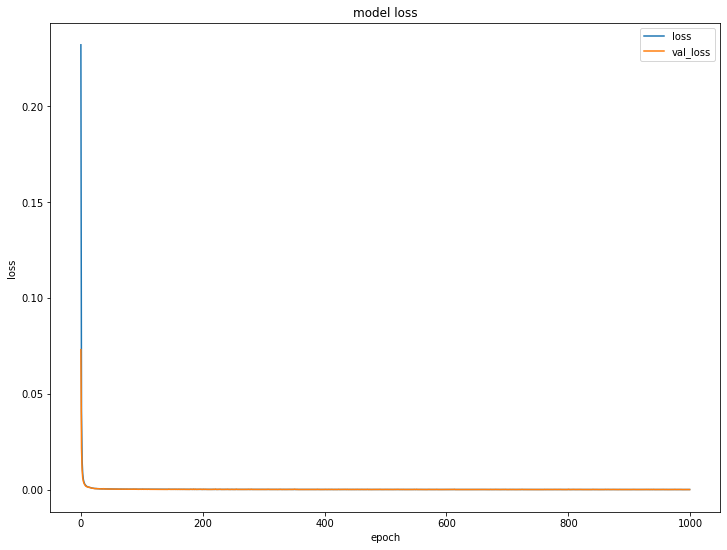

In [ ]:
fig = plt.figure(figsize=(12, 9))
plt.plot(history.history['loss'],"-",label="loss",)
plt.plot(history.history['val_loss'],"-",label="val_loss")
plt.title('model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(loc='best')
plt.show()

**To use Trained Model / To load Trained Model**

In [ ]:
model_best = load_model(model_path_out)

**To predict Test Data**

In [ ]:
y_pred = model_best.predict(x_test)
y_pred_inv = sc_y.inverse_transform(y_pred)
y_test_inv = sc_y.inverse_transform(y_test)

**To see Metrices**

In [ ]:
mtrc = metrics(y_true=y_test_inv, y_pred=y_pred_inv)
print("r2       : %.4f" % mtrc[0])
print("rmse     : %.4f" % mtrc[1])
print("rmse/avg.: %.6f" % (mtrc[1] / abs(y_test_inv.mean())))
print("mae      : %.4f" % mtrc[2])
print("mae/avg. : %.6f" % (mtrc[2] / abs(y_test_inv.mean())))

r2       : 1.0000
rmse     : 63.8534
rmse/avg.: 1.515384
mae      : 44.1591
mae/avg. : 1.047994


**To see the Performance**

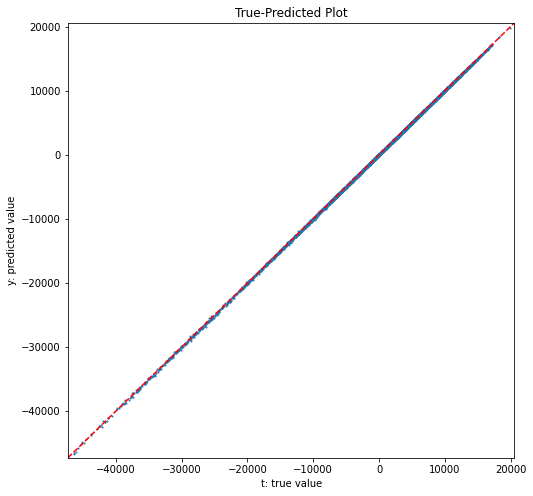

In [ ]:
fig = yyplot(y_true=y_test_inv, y_pred=y_pred_inv)

# **For Optimum Parameter Search**

**To import additional libraries**

In [ ]:
from tqdm import tqdm #To show the progress
import warnings
warnings.filterwarnings('ignore')

**To create Prediction function so as to skip multiple steps**

In [ ]:
def prediction(input_x, model, sc_x, sc_y):
    x_sc = sc_x.transform(input_x)
    y_pred_sc = model.predict(x_sc, batch_size=4096)
#     y_pred_sc = model.predict(x_sc, batch_size=4096, verbose=True)
    y_pred = sc_y.inverse_transform(y_pred_sc)
    return y_pred

To load model **files**

In [ ]:
# Load AI model
model_fff = load_model('/content/drive/MyDrive/Dataset Collection/condifiential/FFF_Flow_best.h5')
model_thermaleff = load_model('/content/drive/MyDrive/Dataset Collection/condifiential/thermaleff_best.h5')
model_specpower = load_model('/content/drive/MyDrive/Dataset Collection/condifiential/SpecPower_best.h5')
model_mche_out_t = load_model('/content/drive/MyDrive/Dataset Collection/condifiential/MCHE_OUT_T_best.h5')

To load Scalar files required for model files

In [ ]:
# Load Scaler used for Model
import pickle
sc_x_fff = pickle.load(open('/content/drive/MyDrive/Dataset Collection/condifiential/FFF_Flow_sc_x.pkl', "rb"))
sc_y_fff= pickle.load(open('/content/drive/MyDrive/Dataset Collection/condifiential/FFF_Flow_sc_y.pkl',"rb"))
sc_x_thermaleff = pickle.load(open('/content/drive/MyDrive/Dataset Collection/condifiential/thermaleff_sc_x.pkl',"rb"))
sc_y_thermaleff = pickle.load(open('/content/drive/MyDrive/Dataset Collection/condifiential/thermaleff_sc_y.pkl',"rb"))
sc_x_specpower = pickle.load(open('/content/drive/MyDrive/Dataset Collection/condifiential/SpecPower_sc_x.pkl',"rb"))
sc_y_specpower = pickle.load(open('/content/drive/MyDrive/Dataset Collection/condifiential/SpecPower_sc_y.pkl',"rb"))
sc_x_mche_out_t = pickle.load(open('/content/drive/MyDrive/Dataset Collection/condifiential/MCHE_OUT_T_sc_x.pkl',"rb"))
sc_y_mche_out_t = pickle.load(open('/content/drive/MyDrive/Dataset Collection/condifiential/MCHE_OUT_T_sc_y.pkl',"rb"))

For loading the data for input,
to list input files.

In [ ]:
# Count File Numbers
data_dir = '/content/drive/MyDrive/Dataset Collection/condifiential/'
data_filelist = os.listdir(data_dir)
file_num = len(data_filelist)
print("file_num:",file_num)
data_filelist

file_num: 16


['conditions.csv',
 'MCHE_OUT_T_best.h5',
 'SpecPower_best.h5',
 'SpecPower_sc_y.pkl',
 'SpecPower_sc_x.pkl',
 'MCHE_OUT_T_sc_x.pkl',
 'MCHE_OUT_T_sc_y.pkl',
 'thermaleff_best.h5',
 'FFF_Flow_sc_x.pkl',
 'FFF_Flow_best.h5',
 'FFF_Flow_sc_y.pkl',
 'thermaleff_sc_x.pkl',
 'thermaleff_sc_y.pkl',
 'csv',
 '.ipynb_checkpoints',
 'FFF_Flow__sc_y.pkl']

To merge multiple dataframe as one.

In [ ]:
# Read Data and Integrate into 1 Data Frame
df_raw = pd.DataFrame()
for i_file in range(file_num):
    file_dir = data_dir + "/" + data_filelist[i_file]
    if file_dir[-3:]=="csv":
        df_tmp = pd.read_csv(file_dir)
        df_raw = pd.concat([df_raw, df_tmp])
df_raw.reset_index(drop=True, inplace=True)
print("df_raw.shape:", df_raw.shape)

ParserError: ignored

To clean the data as required.

In [ ]:
# remove Note, Unnamed columns and Feasible=0.
df = df_raw.copy()
df.drop(["Note", "Unnamed: 0"], axis = 1, inplace = True)
df = df[df['Feasible'] != 0]
print("df.shape:", df.shape)
df.describe()

To prepare input Lists

In [ ]:
# explanatory variable - given
list_u = ['FEED_N2', 'FEED_C1', 'FEED_C2','FEED_C3', #'FEED_iC4', 'FEED_nC4','FEED_C5+',
    'AmbTemp', 'C3_CON_OUT', # 'MCHE_IN_T',
    'WB_UA', 'CB_UA', #"Sub_Out_Temp_AFC","Cooler_Out_Temp_AFC",
         ]

# explanatory variable - search
list_v = ['P_HPMR', 'P_LPMR', 'MCHE_BTM_DT', 
          #'MR_N2',
          'MR_C1', 'MR_C2', 'MR_C3', #'MR_C4'
         ]

# For Result
list_result = list_v + ["FFF_Flow_pred",'ThermalEff_pred',
                        'SpecPower_pred', "MCHE_CB_Out_Temp_pred"
                       ]

# explanatory variable
list_x = list_u + list_v 

To apply Center Values

In [ ]:
# Fix UA with Center Value
df[['WB_UA', 'CB_UA']] = df[['WB_UA', 'CB_UA']].quantile(0.5).values

To remove Duplicates while copying

In [ ]:
# Prepare df
df_u = df.loc[:, list_u].copy().drop_duplicates()
df_v = df.loc[:, list_v].copy().drop_duplicates()
df_x = df.loc[:, list_x].copy().drop_duplicates()

To write search results with input data

In [ ]:
df_training = df_u.copy()

Searching results for all parameters

In [ ]:
output_file_num = 10 #Separation of df_training
df_total_row = df_training.shape[0]//output_file_num
print("df_total_row_per_1_file:", df_total_row)

# Optimum Parameter Search
for j in range(output_file_num):

    for row, u in tqdm(df_training[j*df_total_row:(j+1)*df_total_row].iterrows()):
        df_search = df_v.copy()
        for col in list_u:
            df_search[col] = u[col]
        df_search = df_search.loc[:, list_x]

        input_x = df_search[list_x].values

        df_search["FFF_Flow_pred"] = prediction(input_x, model_fff, sc_x_fff, sc_y_fff)
        df_search["ThermalEff_pred"] = prediction(input_x, model_thermaleff, sc_x_thermaleff, sc_y_thermaleff)
        df_search["SpecPower_pred"] = prediction(input_x, model_specpower, sc_x_specpower, sc_y_specpower)
        df_search["MCHE_CB_Out_Temp_pred"] = prediction(input_x, model_mche_out_t, sc_x_mche_out_t, sc_y_mche_out_t)
        df_search = df_search[df_search["FFF_Flow_pred"] > 0]
        max_thermal = df_search["ThermalEff_pred"].max()
        rs_best = df_search[df_search["ThermalEff_pred"] == max_thermal]
        rs_best1 = df_search[df_search["ThermalEff_pred"] > max_thermal * 0.9999]
        rs_best2 = df_search[df_search["ThermalEff_pred"] > max_thermal * 0.9998]

        # Number of extracted row
        df_training.loc[row, 'Best1_Count'] = rs_best1.shape[0]
        df_training.loc[row, 'Best2_Count'] = rs_best2.shape[0]

        # write results
        for col in list_result:
            df_training.loc[row, 'Best_' + col + '_MEAN'] = rs_best[col].mean()

            df_training.loc[row, 'Best1_' + col + '_MIN'] = rs_best1[col].min()
            df_training.loc[row, 'Best1_' + col + '_MAX'] = rs_best1[col].max()
            df_training.loc[row, 'Best1_' + col + '_MEAN'] = rs_best1[col].mean()
            df_training.loc[row, 'Best1_' + col + '_STD'] = rs_best1[col].std()
            
            df_training.loc[row, 'Best2_' + col + '_MIN'] = rs_best2[col].min()
            df_training.loc[row, 'Best2_' + col + '_MAX'] = rs_best2[col].max()
            df_training.loc[row, 'Best2_' + col + '_MEAN'] = rs_best2[col].mean()
            df_training.loc[row, 'Best2_' + col + '_STD'] = rs_best2[col].std()

    df_training[j*df_total_row:(j+1)*df_total_row].to_pickle('csv/searched_{}.pkl'.format(j))
    df_training[j*df_total_row:(j+1)*df_total_row].to_csv('csv/searched_{}.csv'.format(j))

0it [00:00, ?it/s]

df_total_row_per_1_file: 7325


7325it [52:39,  2.32it/s]
1019it [07:20,  2.36it/s]